In [ ]:
!pip install transformers accelerate datasets peft==0.5.0 --quiet
!pip install --upgrade git+https://github.com/huggingface/diffusers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline, DDPMScheduler
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as T
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
import os

MODEL_NAME = "runwayml/stable-diffusion-v1-5"
DATASET_NAME = "lambdalabs/naruto-blip-captions"
IMAGE_SIZE = 256

class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, tokenizer, transform):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = data["image"] if isinstance(data["image"], Image.Image) else Image.open(data["image"]).convert("RGB")
        # image = Image.open(data["image"]).convert("RGB")
        image = self.transform(image)

        tokens = self.tokenizer(
            data["text"],
            truncation=True,
            padding="max_length",
            max_length=77,
            return_tensors="pt"
        )
        return {
            "pixel_values": image,
            "input_ids": tokens.input_ids[0]
        }

def main():
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    # Load base pipeline
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_NAME, torch_dtype=torch.float16
    ).to(device)

    # Freeze VAE and text encoder
    pipe.vae.requires_grad_(False)
    pipe.text_encoder.requires_grad_(False)

    # Prepare LoRA config for U-Net
    lora_config = LoraConfig(
        r=4, lora_alpha=32, target_modules=["to_q", "to_k", "to_v"], lora_dropout=0.1,
        bias="none", task_type="UNET"
    )

    unet = get_peft_model(pipe.unet, lora_config)
    unet.train()

    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder
    vae = pipe.vae
    scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

    # Load dataset (small subset for quick training)
    dataset = load_dataset(DATASET_NAME, split="train[:1220]")
    transform = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize([0.5], [0.5])
    ])
    train_ds = ImageCaptionDataset(dataset, tokenizer, transform)
    dataloader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True)

    optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

    unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)

    for epoch in range(15):  # small for quick training
        for step, batch in enumerate(dataloader):
            with torch.no_grad():
                # Cast pixel_values to float16 before passing to the VAE
                latents = vae.encode(batch["pixel_values"].type(torch.float16).to(device)).latent_dist.sample() * 0.18215
                text_embeds = text_encoder(batch["input_ids"].to(device))[0]

            # noise = torch.randn_like(latents)
            noise = torch.randn_like(latents, dtype=torch.float16)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=device).long()
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            # Cast noisy_latents and text_embeds to float32 before passing to unet
            noise_pred = unet(noisy_latents.type(torch.float32), timesteps, encoder_hidden_states=text_embeds.type(torch.float32)).sample

            # Cast noise_pred and noise to float32 before calculating loss
            loss = torch.nn.functional.mse_loss(noise_pred.type(torch.float32), noise.type(torch.float32))

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            if step % 20 == 0:
                print(f"[Epoch {epoch} | Step {step}] Loss: {loss.item():.4f}")

    accelerator.wait_for_everyone()
    unet.save_pretrained("./lora-unet")
    print("✅ LoRA U-Net weights saved at ./lora-unet")

if __name__ == "__main__":
    main()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

(…)-00000-of-00002-12944970063701d5.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

(…)-00001-of-00002-cefa2f480689f147.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

[Epoch 0 | Step 0] Loss: 0.2814
[Epoch 0 | Step 20] Loss: 0.0968
[Epoch 0 | Step 40] Loss: 0.0176
[Epoch 0 | Step 60] Loss: 0.1523
[Epoch 0 | Step 80] Loss: 0.1808
[Epoch 0 | Step 100] Loss: 0.2304
[Epoch 0 | Step 120] Loss: 0.1742
[Epoch 0 | Step 140] Loss: 0.2306
[Epoch 0 | Step 160] Loss: 0.1208
[Epoch 0 | Step 180] Loss: 0.0742
[Epoch 0 | Step 200] Loss: 0.0107
[Epoch 0 | Step 220] Loss: 0.2596
[Epoch 0 | Step 240] Loss: 0.0681
[Epoch 0 | Step 260] Loss: 0.1050
[Epoch 0 | Step 280] Loss: 0.2085
[Epoch 0 | Step 300] Loss: 0.4051
[Epoch 0 | Step 320] Loss: 0.0854
[Epoch 0 | Step 340] Loss: 0.0992
[Epoch 0 | Step 360] Loss: 0.0297
[Epoch 0 | Step 380] Loss: 0.1406
[Epoch 0 | Step 400] Loss: 0.0678
[Epoch 0 | Step 420] Loss: 0.1533
[Epoch 0 | Step 440] Loss: 0.1656
[Epoch 0 | Step 460] Loss: 0.1275
[Epoch 0 | Step 480] Loss: 0.0871
[Epoch 0 | Step 500] Loss: 0.0211
[Epoch 0 | Step 520] Loss: 0.1675
[Epoch 0 | Step 540] Loss: 0.0265
[Epoch 0 | Step 560] Loss: 0.0666
[Epoch 0 | Step 580]

In [ ]:
prompt = "Naruto eating ramen"

# Baseline Model Image Generation

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

def generate_baseline(prompt):
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16
    ).to("cuda" if torch.cuda.is_available() else "cpu")

    image = pipe(prompt, num_inference_steps=30).images[0]
    image.save("baseline_output.png")
    print("🖼️ Baseline image saved as baseline_output.png")

if __name__ == "__main__":
    generate_baseline(prompt)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

🖼️ Baseline image saved as baseline_output.png


In [ ]:
import shutil
shutil.make_archive("lora-unet", 'zip', "./lora-unet")

'/content/lora-unet.zip'

In [ ]:
from google.colab import files
files.download("lora-unet.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fine Tuned Model Image Generation

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftConfig, get_peft_model

def generate(prompt):
    base_model = "runwayml/stable-diffusion-v1-5"
    lora_path = "./lora-unet"

    pipe = StableDiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16
    ).to("cuda" if torch.cuda.is_available() else "cpu")

    # Disable NSFW safety checker correctly
    def dummy_checker(images, **kwargs):
        return images, [False] * len(images)

    pipe.safety_checker = dummy_checker

    # Load LoRA adapter
    peft_config = PeftConfig.from_pretrained(lora_path)
    pipe.unet = get_peft_model(pipe.unet, peft_config)
    pipe.unet.load_adapter(lora_path, adapter_name="default")

    image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    image.save("lora_output.png")
    print("🖼️ Image saved as lora_output.png")

if __name__ == "__main__":
    generate("Naruto eating ramen")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

🖼️ Image saved as lora_output.png


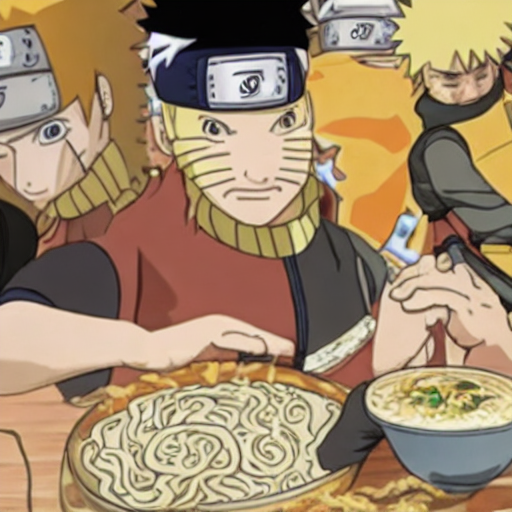

In [ ]:
from IPython.display import Image, display

display(Image(filename="lora_output.png"))

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import torch.nn.functional as F

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval().cuda()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_cosine_similarity(prompt, image):
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        text_emb = clip_model.get_text_features(inputs["input_ids"])
        image_emb = clip_model.get_image_features(inputs["pixel_values"])

    # Normalize and compute cosine similarity
    text_emb = F.normalize(text_emb, p=2, dim=-1)
    image_emb = F.normalize(image_emb, p=2, dim=-1)
    similarity = (text_emb @ image_emb.T).item()
    return similarity


# Usage
img = Image.open("lora_output.png")
score = compute_clip_cosine_similarity(prompt, img)
print("CLIP Score:", score)


CLIP Score: 0.3464020788669586
